In [1]:
# !pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

torch:  1.9 ; cuda:  cu102


In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# import matplotlib
from matplotlib import pyplot as plt

from pathlib import Path

In [3]:
dataset_dir = Path('./datasets/Argoverse')
images_dir = dataset_dir / 'Argoverse-1.1'/ 'images'
annotations_dir = dataset_dir / 'Argoverse-HD/annotations'

In [4]:
str(dataset_dir)

'datasets/Argoverse'

In [ ]:
import json

from tqdm import tqdm
from utils.general import download, Path

dir = Path('../datasets/Argoverse')  # dataset root dir
urls = ['https://argoverse-hd.s3.us-east-2.amazonaws.com/Argoverse-HD-Full.zip']
download(urls, dir=dir, delete=False)


def argoverse2yolo(set):
    labels = {}
    a = json.load(open(set, "rb"))
    for annot in tqdm(a['annotations'], desc=f"Converting {set} to YOLOv5 format..."):
        img_id = annot['image_id']
        img_name = a['images'][img_id]['name']
        img_label_name = img_name[:-3] + "txt"

        cls = annot['category_id']  # instance class id
        x_center, y_center, width, height = annot['bbox']
        x_center = (x_center + width / 2) / 1920.0  # offset and scale
        y_center = (y_center + height / 2) / 1200.0  # offset and scale
        width /= 1920.0  # scale
        height /= 1200.0  # scale

        img_dir = set.parents[2] / 'Argoverse-1.1' / 'labels' / a['seq_dirs'][a['images'][annot['image_id']]['sid']]
        if not img_dir.exists():
            img_dir.mkdir(parents=True, exist_ok=True)

        k = str(img_dir / img_label_name)
        if k not in labels:
            labels[k] = []
        labels[k].append(f"{cls} {x_center} {y_center} {width} {height}\n")

    for k in labels:
        with open(k, "w") as f:
            f.writelines(labels[k])

In [5]:
from detectron2.structures import BoxMode
from tqdm import tqdm
import json

def get_argoverse_dicts(annotations_path, images_path):
    with open(annotations_path) as f:
        metadata = json.load(f)

    dataset_dicts = []
    labels = {}
    for annot in tqdm(metadata['annotations'], desc=f"Generating custom dataset dict for detectron2..."):
        img_id = annot['image_id']
        img_name = metadata['images'][img_id]['name']
        img_height = metadata['images'][img_id]['height']
        img_width = metadata['images'][img_id]['width']
        
        cls = annot['category_id']
        x, y, width, height = annot['bbox']
#         bottom_right_x, bottom_right_y = top_left_x + width, top_left_y + height
        obj = {
#                 "bbox": [top_left_x, top_left_y, bottom_right_x, bottom_right_y],
                "bbox": [x, y, width, height],
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": cls,
        }
        img_dir = images_path / metadata['seq_dirs'][metadata['images'][img_id]['sid']]
        
        if img_id not in labels:
            labels[img_id] = {
                "file_name": str(img_dir / img_name),
                "image_id": img_id,
                "height": img_height,
                "width": img_width,
                "annotations": [],
            }
        labels[img_id]["annotations"].append(obj)
    return list(labels.values())
        
    
#     for idx, v in enumerate(imgs_anns.values()):
#         record = {}
        
#         filename = os.path.join(img_dir, v["filename"])
#         height, width = cv2.imread(filename).shape[:2]
        
#         record["file_name"] = filename
#         record["image_id"] = idx
#         record["height"] = height
#         record["width"] = width
      
#         annos = v["regions"]
#         objs = []
#         for _, anno in annos.items():
#             assert not anno["region_attributes"]
#             anno = anno["shape_attributes"]
#             px = anno["all_points_x"]
#             py = anno["all_points_y"]
#             poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
#             poly = [p for x in poly for p in x]

#             obj = {
#                 "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
#                 "bbox_mode": BoxMode.XYXY_ABS,
#                 "segmentation": [poly],
#                 "category_id": 0,
#             }
#             objs.append(obj)
#         record["annotations"] = objs
#         dataset_dicts.append(record)
#     return dataset_dicts


In [6]:
CLASSES = ['person',  'bicycle',  'car',  'motorcycle',  'bus',  'truck',  'traffic_light',  'stop_sign']

In [7]:
for d in ["train", "val"]:
    DatasetCatalog.register("argo_" + d, lambda d=d: get_argoverse_dicts(str(annotations_dir) + f"/{d}.json", images_dir))
    MetadataCatalog.get("argo_" + d).set(thing_classes=CLASSES)
argoverse_metadata = MetadataCatalog.get("argo_train")

In [8]:
plt.rcParams["figure.figsize"] = (20,15)

Generating custom dataset dict for detectron2...: 100%|██████████| 771774/771774 [00:10<00:00, 70765.11it/s]


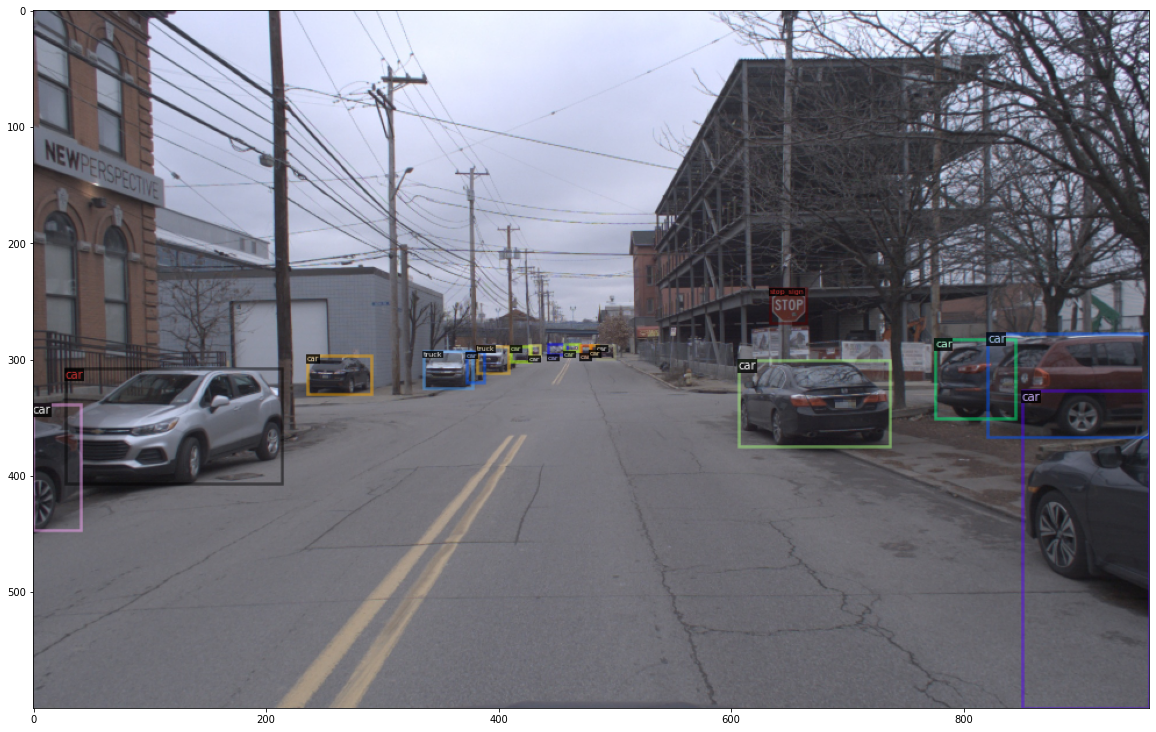

In [9]:
dataset_dicts = get_argoverse_dicts(annotations_dir / "train.json", images_dir)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=argoverse_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image())

In [10]:
dataset_dicts[0]

{'file_name': 'datasets/Argoverse/Argoverse-1.1/images/train/02cf0ce1-699a-373b-86c0-eb6fd5f4697a/ring_front_center/ring_front_center_315968494014028296.jpg',
 'image_id': 0,
 'height': 1200,
 'width': 1920,
 'annotations': [{'bbox': [898, 584, 251, 228],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 2},
  {'bbox': [459, 425, 408, 362],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 5},
  {'bbox': [416, 272, 27, 72],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 6},
  {'bbox': [655, 283, 25, 71],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 6},
  {'bbox': [211, 395, 20, 52],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 6},
  {'bbox': [306, 422, 17, 39],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 6},
  {'bbox': [173, 558, 162, 75],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 5},
  {'bbox': [368, 583, 63, 39],
   'bbox_mode': <BoxMode.XYWH_ABS: 1>,
   'category_id': 5},
  {'bbox': [4, 597, 93, 40],
   'bbo

In [11]:
len(dataset_dicts)

39372

In [12]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("argo_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 2500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05      # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 8   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(CLASSES)  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[11/14 20:20:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Generating custom dataset dict for detectron2...: 100%|██████████| 771774/771774 [00:10<00:00, 70198.66it/s]


[11/14 20:20:28 d2.data.build]: Removed 0 images with no usable annotations. 39372 images left.
[11/14 20:20:31 d2.data.build]: Distribution of instances among all 8 categories:
|   category    | #instances   |  category  | #instances   |  category  | #instances   |
|:-------------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    person     | 89795        |  bicycle   | 8372         |    car     | 486022       |
|  motorcycle   | 4090         |    bus     | 6532         |   truck    | 76494        |
| traffic_light | 95018        | stop_sign  | 5451         |            |              |
|     total     | 771774       |            |              |            |              |
[11/14 20:20:31 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/14 20:20:31 d2.data.build]: Using training sampler TrainingSampler
[11/1

model_final_280758.pkl: 167MB [00:11, 14.2MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (9, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (9,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (32, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (32,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.bo

[11/14 20:20:45 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.6/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


ERROR [11/14 20:20:46 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/detectron2/engine/train_loop.py", line 149, in train
    self.run_step()
  File "/usr/local/lib/python3.6/dist-packages/detectron2/engine/defaults.py", line 494, in run_step
    self._trainer.run_step()
  File "/usr/local/lib/python3.6/dist-packages/detectron2/engine/train_loop.py", line 273, in run_step
    loss_dict = self.model(data)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/detectron2/modeling/meta_arch/rcnn.py", line 154, in forward
    features = self.backbone(images.tensor)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py", line 1051, in _call_impl
    return forward_call(*input, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/detectron2/modeling/ba

RuntimeError: CUDA out of memory. Tried to allocate 60.00 MiB (GPU 0; 2.94 GiB total capacity; 1.43 GiB already allocated; 48.12 MiB free; 1.47 GiB reserved in total by PyTorch)

In [25]:
torch.cuda.empty_cache()